In [1]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# LOAD THE DATA

In [2]:


# Load Data
graph = pd.read_csv('data/graph.csv')

graph

,source,target,weight
0,1084949174,1050463558,1
1,1084949174,1002148361,1
2,1084949174,1000741574,1
3,1084949174,1019020642,1
4,1084949174,1044910984,1
...,...,...,...
94879,1051021947,1003736990,1
94880,1049442903,1010058843,1
94881,1094656395,1024023012,1
94882,1040286105,1071783991,1


In [3]:
dataset = pd.read_json('data/dataset.json')

dataset

,timestamp,text,text_id,user,user_id
0,2024-10-31 00:00:00,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112
1,2024-10-31 00:00:00,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430
2,2024-10-31 00:00:00,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642
3,2024-10-31 00:00:00,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480
4,2024-10-31 00:00:00,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936
...,...,...,...,...,...
70255,2024-10-31 23:59:52,"@bakerjulie: ""Saranghae, I’m your resident K-P...",2086649509,valdezjennifer,1094330726
70256,2024-10-31 23:59:52,Soaring to new heights with @sweeneyanthony! T...,2039889186,nashshaun,1015245531
70257,2024-10-31 23:59:54,"Hey @james20 @paul47, did you see the latest f...",2020468196,brownregina,1029384492
70258,2024-10-31 23:59:58,Check out the fundraiser exhibition by @joanna...,2037744299,dkey,1046050046


# PCA

Scenarios Where PCA Is Commonly Used
Text Clustering: Dimensionality reduction of TF-IDF matrices using PCA before applying clustering algorithms like k-means.
Text Visualization: Reducing high-dimensional text representations to 2D/3D for plotting.
Preprocessing in NLP Pipelines: Compressing large text feature spaces into more manageable sizes.

## Step 1: Preprocessing the data



PCA requires a numerical data representation to be able to calculate Eigenvectors etc. during its process:

### Step 1.1: Preprocess dataset.json



Possible Approach:

*Dataset 1: dataset.json*
Features:
- timestamp: Can be converted to a numerical format (e.g., Unix timestamp or days from a reference date).
- text: Cannot directly be used; instead, we can use text embedding techniques like *TF-IDF* or sentence embeddings to represent this as numerical data.
- text_id, user, user_id: Unique identifiers; user_id and text_id may be relevant for joining or relational purposes but not for PCA directly.

In [4]:
# Clone the dataset for PCA
dataset_pca = dataset.copy()

##### Step 1.1.1 Convert Timestamp to integer-format

In [5]:
# Convert timestamp to numerical format

# get the earliest timestamp
earliest_timestamp = dataset_pca['timestamp'].min()

# use the earliest timestamp as the base, and convert the timestamp to seconds
dataset_pca['timestamp'] = (dataset_pca['timestamp'] - earliest_timestamp).dt.total_seconds()

dataset_pca['timestamp']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
70255    86392.0
70256    86392.0
70257    86394.0
70258    86398.0
70259    86399.0
Name: timestamp, Length: 70260, dtype: float64

#### Step 1.1.2: Preprocessing of `text`.

**Cleaning the `text` field of irrelevant data**
   - Remove stopwords from the `text`-field, store the result in a new column **text_preprocessed** 


**Transforming Text Data into Numerical Features**
   - The `text` field in the dataset is converted into numerical features using the **TF-IDF (Term Frequency-Inverse Document Frequency)** method.
   - **Reasoning**: TF-IDF captures the importance of words in each document relative to the entire corpus, emphasizing unique and meaningful terms while down-weighting commonly occurring ones (e.g., stopwords).


**Handling Sparsity with TruncatedSVD**
   - Since TF-IDF produces a sparse matrix, **TruncatedSVD** is used to reduce dimensionality while retaining as much variance as possible.
   - **Why SVD instead of PCA**: TruncatedSVD handles sparse matrices efficiently without requiring dense conversion.

##### Step 1.1.2.1 Cleaning of 'Text' field

In [6]:

tfidf_vectorizer_raw = TfidfVectorizer(max_features=500)
text_features_raw = tfidf_vectorizer_raw.fit_transform(dataset_pca['text'])
feature_names_raw = tfidf_vectorizer_raw.get_feature_names_out()

# Compute average scores again
tfidf_matrix_raw = text_features_raw.toarray()
average_tfidf_scores_raw = np.mean(tfidf_matrix_raw, axis=0)
sorted_features_raw = sorted(zip(feature_names_raw, average_tfidf_scores_raw), key=lambda x: x[1], reverse=True)

print("Top 50 TF-IDF Features After Preprocessing:")
for term, score in sorted_features_raw[:50]:
    print(f"{term}: {score:.4f}")

Top 50 TF-IDF Features After Preprocessing:
the: 0.0983
to: 0.0710
and: 0.0681
for: 0.0637
co: 0.0563
https: 0.0560
of: 0.0507
in: 0.0495
it: 0.0432
is: 0.0429
your: 0.0377
on: 0.0367
with: 0.0358
business: 0.0356
health: 0.0332
you: 0.0281
out: 0.0273
this: 0.0271
our: 0.0268
at: 0.0251
can: 0.0250
let: 0.0238
yhawkins: 0.0228
are: 0.0214
we: 0.0214
check: 0.0203
from: 0.0198
politics: 0.0193
just: 0.0192
that: 0.0190
all: 0.0186
time: 0.0178
about: 0.0176
as: 0.0176
more: 0.0176
my: 0.0174
be: 0.0174
vote: 0.0163
not: 0.0156
their: 0.0156
science: 0.0156
by: 0.0154
support: 0.0148
new: 0.0146
don: 0.0146
like: 0.0146
but: 0.0137
make: 0.0136
up: 0.0135
here: 0.0132


The above are the top 50 words ranked by importance. We can see many stopwords like `the`, `to`, `and`, `for`, `of`, `in`, `is`. They are high-frequency, low-information terms and need irrelevant for the analysis.

Words like `co` and `https` suggest that URLs or special tokens are present in the text. We remove these aswell.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import numpy as np

# Preprocessing: Remove unwanted patterns from text
dataset_pca['text_preprocessed'] = dataset_pca['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)  # Remove URLs
dataset_pca['text_preprocessed'] = dataset_pca['text_preprocessed'].str.replace(r'\bhttps\b', '', regex=True)  # Remove standalone 'https'
dataset_pca['text_preprocessed'] = dataset_pca['text_preprocessed'].str.replace(r'\b\d+\b', '', regex=True)  # Remove standalone numbers

# Define additional words to remove
custom_stop_words = {'just', 'let', 'make', 'hey'}

# Combine custom stop words with English stop words
all_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))  # Convert to list

# Initialize TfidfVectorizer with the combined stop words
# TODO: Stemming and lemmatization can be added here
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)

# Fit and transform the text data
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Compute average TF-IDF scores
tfidf_matrix = text_features.toarray()
average_tfidf_scores = np.mean(tfidf_matrix, axis=0)
sorted_features = sorted(zip(feature_names, average_tfidf_scores), key=lambda x: x[1], reverse=True)

# Display the top 50 features
print("Top 50 TF-IDF Features After Preprocessing:")
for term, score in sorted_features[:50]:
    print(f"{term}: {score:.4f}")

# Validate that unwanted words are removed
print(f"Unwanted words still in vocabulary: {custom_stop_words.intersection(set(feature_names))}")


Top 50 TF-IDF Features After Preprocessing:
business: 0.0448
health: 0.0414
yhawkins: 0.0273
politics: 0.0260
check: 0.0254
time: 0.0229
vote: 0.0199
like: 0.0198
science: 0.0196
don: 0.0184
support: 0.0183
new: 0.0178
climate: 0.0159
love: 0.0146
social: 0.0141
need: 0.0136
world: 0.0130
artist: 0.0124
voting: 0.0122
btsbbmas: 0.0121
people: 0.0119
mental: 0.0117
join: 0.0115
healthcare: 0.0115
latest: 0.0113
best: 0.0112
ready: 0.0107
high: 0.0101
rt: 0.0101
bbmas: 0.0100
army: 0.0098
change: 0.0098
crucial: 0.0097
real: 0.0096
help: 0.0093
wait: 0.0093
stay: 0.0093
looking: 0.0093
energy: 0.0092
low: 0.0092
impact: 0.0091
bts: 0.0090
miss: 0.0090
work: 0.0090
care: 0.0086
important: 0.0084
believe: 0.0084
power: 0.0082
learn: 0.0082
news: 0.0079
Unwanted words still in vocabulary: set()


The irrelevant words are removed.

##### Step 1.1.2.2 Pick a value for max_features

**Limiting the Vocabulary (`max_features=500`)**
   - To manage the high dimensionality of textual data, only the **top 500 most relevant terms** are retained.
   - **Justification**: 
     - This decision balances computational efficiency with information retention.
     - The cumulative explained variance plot for different `max_features` values showed that 500 features provide a good trade-off.


If max_features=500, only the 500 most frequent and impactful terms will be retained, while the rest are discarded.

In [9]:
issparse(text_features)

True

**Use TruncatedSVD instead of PCA to handle sparsity**
   - Since TF-IDF produces a sparse matrix, **TruncatedSVD** is used to reduce dimensionality while retaining as much variance as possible.
   - TruncatedSVD handles sparse matrices efficiently without requiring dense conversion.

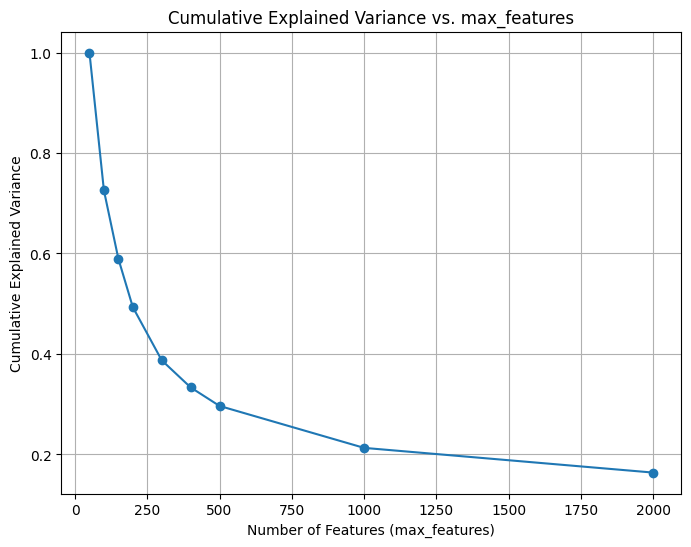

In [21]:


# Test different values for max_features
feature_sizes = [ 50, 100, 150, 200, 300, 400, 500, 1000, 2000]
explained_variances = []

for max_features in feature_sizes:
    
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words=all_stop_words)
    text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
    
    # Apply SVD
    svd = TruncatedSVD(n_components=50, random_state=42)
    svd.fit(text_features)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(feature_sizes, explained_variances, marker='o')
plt.title('Cumulative Explained Variance vs. max_features')
plt.xlabel('Number of Features (max_features)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


Cumulative explained variance measures how much of the total variability in the data is captured by the selected features.

The number of SVD components is fixed at 𝑛_𝑐𝑜𝑚𝑝𝑜𝑛𝑒𝑛𝑡𝑠 = 50. If max_features is large, it includes the additional features are irrelevant or noisy, the top 50 components explain less variance when the feature space grows.

When max_features is small (e.g., 250 or 500), the TF-IDF vectorizer focuses only on the most frequent and impactful terms, which tend to capture a large portion of the variability in the text data. This is why higher max_feature values lead to smaller cumulative explained variance: The added features dilute the relative contribution of the most impactful features, so the variance captured by the top components in SVD appears smaller.


**max_features=500 is a good choice because it captures a large portion of the variance** -> Only the 500 most frequent and impactful terms will be retained, while the rest are discarded.

In [22]:


# Use fixed max_features=500 based on previous decision
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Compute the average TF-IDF score for each feature (term)
average_tfidf_scores = np.mean(text_features.toarray(), axis=0)

# Pair each feature name with its average score
important_features = sorted(zip(feature_names, average_tfidf_scores), key=lambda x: x[1], reverse=True)

# Print the top 20 most important features
print("Top 20 Most Important Features:")
for term, score in important_features[:20]:
    print(f"{term}: {score:.4f}")



Top 20 Most Important Features:
business: 0.0448
health: 0.0414
yhawkins: 0.0273
politics: 0.0260
check: 0.0254
time: 0.0229
vote: 0.0199
like: 0.0198
science: 0.0196
don: 0.0184
support: 0.0183
new: 0.0178
climate: 0.0159
love: 0.0146
social: 0.0141
need: 0.0136
world: 0.0130
artist: 0.0124
voting: 0.0122
btsbbmas: 0.0121


##### Step 1.1.2.3 Pick a value for n_components




To optimize the number of components (`n_components`), the **cumulative explained variance** was analyzed for different values. This helps determine how much information is retained as the dimensionality is reduced.

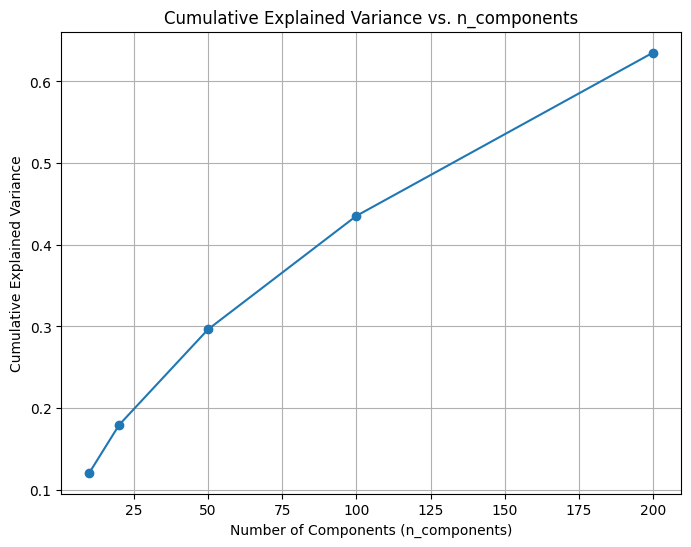

In [23]:

# Test different values for n_components
n_components_list = [10, 20, 50, 100, 200]
cumulative_variances = []

for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(text_features)
    cumulative_variances.append(svd.explained_variance_ratio_.sum())

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, cumulative_variances, marker='o')
plt.title('Cumulative Explained Variance vs. n_components')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

There's no clear elbow point in this plot: The variance is distributed across many components without a sharp plateau. This is common in text data represented by TF-IDF.

We can run the downstream analysis using different values of n_components (50, 100, 200) and compare the results.

#### Step 1.1.2.4 Incorporate Features into the dataset



In [25]:
### STEPS SO FAR ###

# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Reduce dimensionality using TruncatedSVD
# Define the number of components for dimensionality reduction
final_n_components = 50  # We will test different values later

# Apply TruncatedSVD to reduce the dimensionality of the TF-IDF matrix
svd = TruncatedSVD(n_components=final_n_components, random_state=42)
svd_features = svd.fit_transform(text_features)

# Step 3: Analyze SVD components
# Each SVD component represents a latent concept; we analyze the top words contributing to each component
components = svd.components_  # Shape: (n_components, n_features)

# Define the number of top words to display for each component
top_n_words = 10

# Display the top contributing words for each SVD component
print(f"Top {top_n_words} words contributing to each of the {final_n_components} SVD components:\n")

for i, component in enumerate(components):
    # Sort the features (words) by their importance (absolute weight) in the component
    top_indices = component.argsort()[::-1][:top_n_words]  # Indices of top N words
    top_words = [feature_names[j] for j in top_indices]    # Get the corresponding words
    top_weights = component[top_indices]                  # Get the weights for these words

    # Print the component number and the top words with their weights
    print(f"Component {i + 1}:")
    for word, weight in zip(top_words, top_weights):
        print(f"  {word}: {weight:.4f}")
    print("\n")


Top 10 words contributing to each of the 50 SVD components:

Component 1:
  yhawkins: 0.4544
  vote: 0.3072
  business: 0.2219
  artist: 0.2101
  btsbbmas: 0.2091
  social: 0.2083
  health: 0.1923
  voting: 0.1760
  bbmas: 0.1673
  support: 0.1639


Component 2:
  business: 0.4839
  health: 0.3825
  check: 0.2114
  politics: 0.1558
  new: 0.1092
  mental: 0.1064
  like: 0.1012
  climate: 0.0981
  science: 0.0963
  latest: 0.0820


Component 3:
  climate: 0.4552
  oct: 0.3908
  precip: 0.3890
  snow: 0.3889
  low: 0.3848
  high: 0.3821
  missing: 0.0610
  change: 0.0377
  yhawkins: 0.0286
  crisis: 0.0217


Component 4:
  health: 0.6656
  mental: 0.1986
  healthcare: 0.0932
  care: 0.0926
  prioritize: 0.0686
  mentalhealth: 0.0655
  mentalhealthawareness: 0.0650
  wellness: 0.0636
  secretary: 0.0611
  important: 0.0589


Component 5:
  politics: 0.8965
  like: 0.1343
  political: 0.1154
  time: 0.0868
  people: 0.0859
  science: 0.0648
  change: 0.0524
  focus: 0.0478
  real: 0.0459
 

The SVD components are sorted based on the variance they explain in the original data. First Component explains the most variance, while the last Component explains the least.

In [ ]:
"""
# Create a DataFrame for the reduced features
svd_features_df = pd.DataFrame(
    svd_features, 
    columns=[f"svd_{i}" for i in range(final_n_components)]  # Name components svd_0, svd_1, ...
)

# Combine the reduced features with the original dataset
dataset_pca_combined = pd.concat([dataset_pca.reset_index(drop=True), svd_features_df], axis=1)

# Drop the original text columns if no longer needed
dataset_pca_combined = dataset_pca_combined.drop(['text', 'text_preprocessed'], axis=1)

# Verify the structure of the combined dataset
dataset_pca_combined.head()
"""

### Downstream Analysis for different n_components

In [14]:
# Function to evaluate clustering for a given n_components
def evaluate_clustering(text_features, n_components, n_clusters_range):
    results = []
    
    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd_features = svd.fit_transform(text_features)
    
    # Normalize the features
    scaler = StandardScaler()
    svd_features_normalized = scaler.fit_transform(svd_features)
    
    # Evaluate clustering for different n_clusters
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(svd_features_normalized)
        silhouette = silhouette_score(svd_features_normalized, clusters)
        results.append((n_components, n_clusters, silhouette))
    
    return results


Execute the Pipeline for Multiple n_components

In [ ]:
# Caution: This takes a long time to run!

# Define ranges for n_components and n_clusters
n_components_list = [50, 100, 200]
n_clusters_range = range(2, 11)  # Test between 2 and 10 clusters

# Store all results
all_results = []

for n_components in n_components_list:
    results = evaluate_clustering(text_features, n_components, n_clusters_range)
    all_results.extend(results)

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(all_results, columns=['n_components', 'n_clusters', 'silhouette_score'])

# Display results
print(results_df)


KeyboardInterrupt: 

 Plot Silhouette Scores

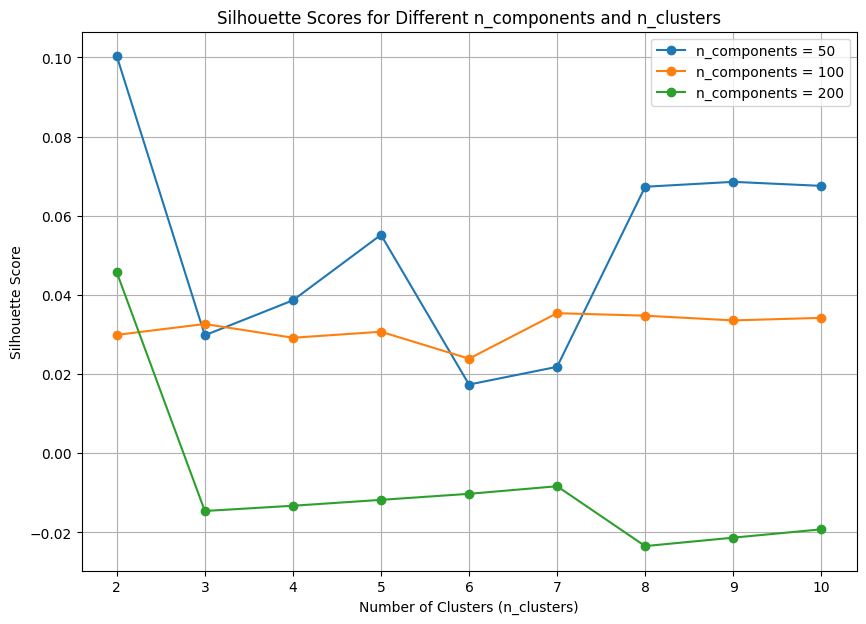

In [22]:
# Plot silhouette scores for each n_components
plt.figure(figsize=(10, 7))

for n_components in n_components_list:
    subset = results_df[results_df['n_components'] == n_components]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'n_components = {n_components}')

plt.title('Silhouette Scores for Different n_components and n_clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()


Best results: 
50 n_components
2, 8-10 Clusters

Apply k_means for 50 components and 8 Clusters (Example)

n_components=10, n_clusters=2, Silhouette Score=0.3382
n_components=10, n_clusters=3, Silhouette Score=0.2138
n_components=10, n_clusters=4, Silhouette Score=0.2753
n_components=10, n_clusters=5, Silhouette Score=0.1819
n_components=10, n_clusters=6, Silhouette Score=0.2630
n_components=10, n_clusters=7, Silhouette Score=0.2876
n_components=10, n_clusters=8, Silhouette Score=0.3585
n_components=10, n_clusters=9, Silhouette Score=0.3836
n_components=10, n_clusters=10, Silhouette Score=0.4191
n_components=20, n_clusters=2, Silhouette Score=0.0489
n_components=20, n_clusters=3, Silhouette Score=0.0671
n_components=20, n_clusters=4, Silhouette Score=0.0822
n_components=20, n_clusters=5, Silhouette Score=0.0952
n_components=20, n_clusters=6, Silhouette Score=0.1118
n_components=20, n_clusters=7, Silhouette Score=0.1395
n_components=20, n_clusters=8, Silhouette Score=0.2012
n_components=20, n_clusters=9, Silhouette Score=0.2047
n_components=20, n_clusters=10, Silhouette Score=0.1536
n_compon

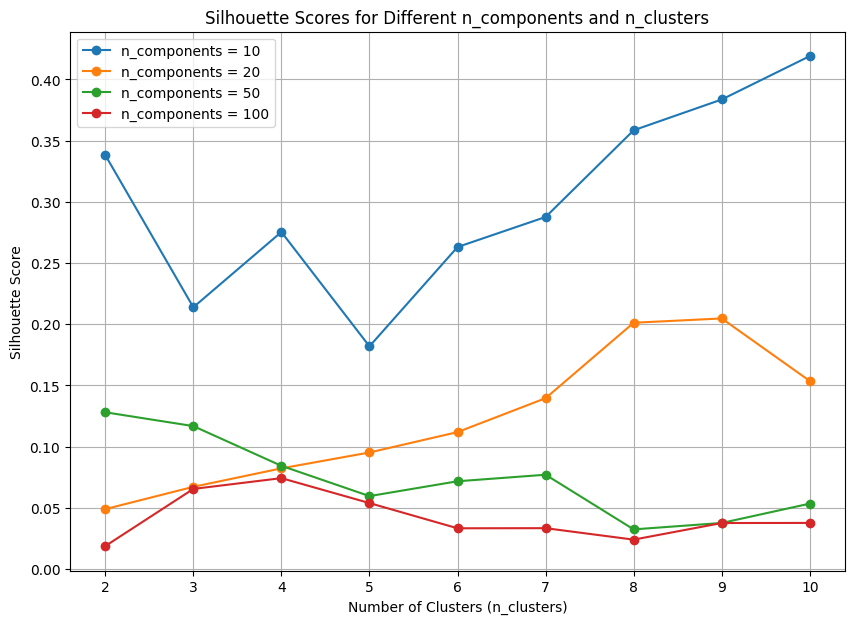


Best Configuration:
n_components: 10
n_clusters: 10
Silhouette Score: 0.4191


In [36]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_clusters_with_components(text_features, n_components_list, n_clusters_range, feature_names):
    """
    Analyzes clustering performance across different n_components and n_clusters.
    
    Parameters:
    - text_features: Sparse matrix of TF-IDF features.
    - n_components_list: List of n_components values to test for dimensionality reduction.
    - n_clusters_range: Range of cluster numbers to evaluate (e.g., range(3, 8)).
    - feature_names: List of feature names from TF-IDF.

    Returns:
    - results_df: DataFrame with silhouette scores for all tested (n_components, n_clusters).
    - best_configuration: Dictionary with the best n_components, n_clusters, silhouette_score, and clusters.
    """
    evaluation_results = []
    best_silhouette_score = -1
    best_configuration = {}

    for n_components in n_components_list:
        # Step 1: Reduce dimensionality using TruncatedSVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_features = svd.fit_transform(text_features)

        # Normalize the SVD features
        scaler = StandardScaler()
        svd_features_normalized = scaler.fit_transform(svd_features)

        # Step 2: Evaluate clustering for different n_clusters
        for n_clusters in n_clusters_range:
            # Use MiniBatchKMeans for faster clustering
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
            clusters = kmeans.fit_predict(svd_features_normalized)

            # Evaluate clustering with silhouette score
            silhouette = silhouette_score(svd_features_normalized, clusters, n_jobs=-1)
            evaluation_results.append({
                'n_components': n_components,
                'n_clusters': n_clusters,
                'silhouette_score': silhouette
            })

            # Track the best clustering configuration
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_configuration = {
                    'n_components': n_components,
                    'n_clusters': n_clusters,
                    'silhouette_score': silhouette,
                    'clusters': clusters,
                    'svd': svd,
                    'kmeans': kmeans
                }

            print(f"n_components={n_components}, n_clusters={n_clusters}, Silhouette Score={silhouette:.4f}")

    # Convert results to a DataFrame for easier visualization
    results_df = pd.DataFrame(evaluation_results)

    return results_df, best_configuration


# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Define the ranges for n_components and n_clusters
n_components_list = [10, 20, 50, 100]  # Adjust based on dataset size and explained variance
n_clusters_range = range(2, 11)

# Analyze clustering performance for different configurations
results_df, best_configuration = analyze_clusters_with_components(
    text_features=text_features,
    n_components_list=n_components_list,
    n_clusters_range=n_clusters_range,
    feature_names=feature_names
)

# Step 3: Plot silhouette scores for each n_components
plt.figure(figsize=(10, 7))

for n_components in n_components_list:
    subset = results_df[results_df['n_components'] == n_components]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'n_components = {n_components}')

plt.title('Silhouette Scores for Different n_components and n_clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Display the best configuration
print("\nBest Configuration:")
print(f"n_components: {best_configuration['n_components']}")
print(f"n_clusters: {best_configuration['n_clusters']}")
print(f"Silhouette Score: {best_configuration['silhouette_score']:.4f}")


For n=70,000 samples, the distance matrix size is approximately 70,000 x 70,000, which requires a significant amount of memory to store.

To solve this use hierarchical clustering for smaller subsets of the data.

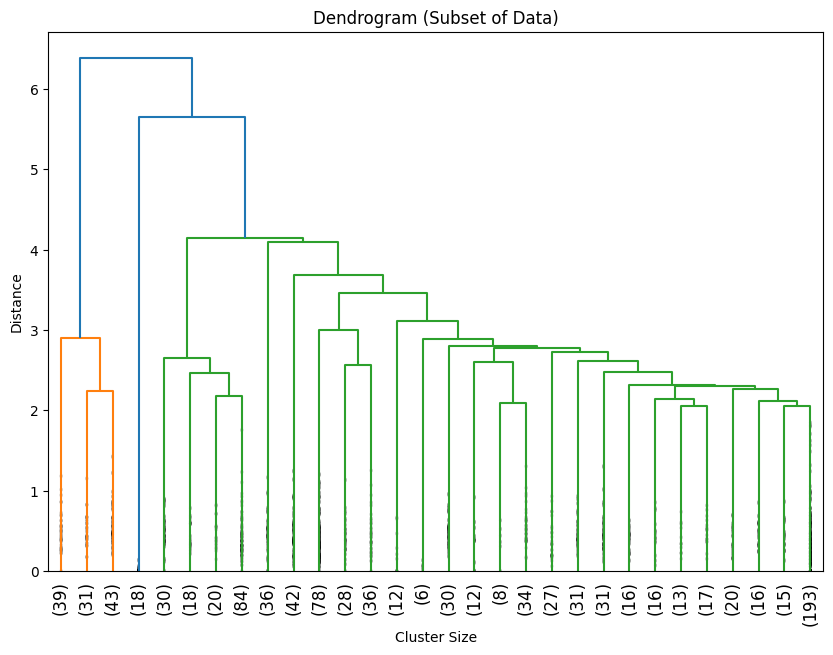

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
import random

# Sample a subset of the data (e.g., 1000 samples)
subset_size = 1000
random_indices = random.sample(range(len(svd_features)), subset_size)
subset = svd_features[random_indices]

# Perform hierarchical clustering
linked = linkage(subset, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Dendrogram (Subset of Data)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


In [ ]:
from sklearn.decomposition import NMF

# Apply NMF to extract topics
nmf = NMF(n_components=10, random_state=42)  # Adjust n_components as needed
nmf_topics = nmf.fit_transform(text_features)

# Inspect the top terms in each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}: ", " ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 0:  yhawkins vote artist btsbbmas social bbmas voting army rt love
Topic 1:  business success marketing learn entrepreneurship looking hey help businessgrowth online
Topic 2:  climate oct precip snow low high missing change crisis city
Topic 3:  health mental healthcare care secretary wellness mentalhealth prioritize crucial important
Topic 4:  politics political people like hey focus government party trump truss
Topic 5:  science research world history technology education innovation explore fascinating data
Topic 6:  just like looks believe wait people got real day isn
Topic 7:  unknown climateemergency cop26 times cop26glasgow seen alt scotradar united kingdom
Topic 8:  check latest new looking news article link details stay updates
Topic 9:  let time don make support change miss join ready real


Assign Dominant Topics to Each Document:
Identify the topic with the highest weight for each document in the NMF matrix.

In [19]:
# Assign dominant topics to documents
dominant_topics = nmf_topics.argmax(axis=1)
dataset_pca['dominant_topic'] = dominant_topics

# Inspect sample documents with their dominant topics
print(dataset_pca[['text', 'dominant_topic']].head(10))


NameError: name 'nmf_topics' is not defined

In [66]:
# Clone the graph for PCA
graph_pca = graph.copy()

# Compute numerical features for graph


### Preprocess graph.csv

*Dataset 2: graph.csv*
This dataset represents a graph. To use this for PCA, we can compute numerical features from the graph, such as:
- Degree centrality.
- Betweenness centrality.
- Clustering coefficient.